# Beta Neutral Portfolio Strategy

**Financial beta**, also known as asset beta or levered beta, is a measure of the volatility of a stock or a portfolio of stocks compared to the overall market. It is a crucial component of the capital asset pricing model (CAPM) and is generally used to compare two different asset, most of the time a stock to its respective ETF (*Exchange Traded Fund*).

Mathematically, beta is defined as the covariance of the asset's returns with the market returns divided by the variance of the market returns. In other words, beta measures how much an asset's returns move in relation to the market's returns or comparison point.

Beta is typically calculated using historical data, and a beta of 1 indicates that the asset's returns move in line with the market. A beta greater than 1 indicates that the asset is more volatile than the market, while a beta less than 1 indicates that the asset is less volatile than the market. These effects are important to understand, as a higher beta implies a higher expected return but also higher risk, while a lower beta implies a lower expected return but lower risk.

Here's a more graphical exemple of this factor between QQQ, an ETF composed of S&P500 stocks, and different assets:



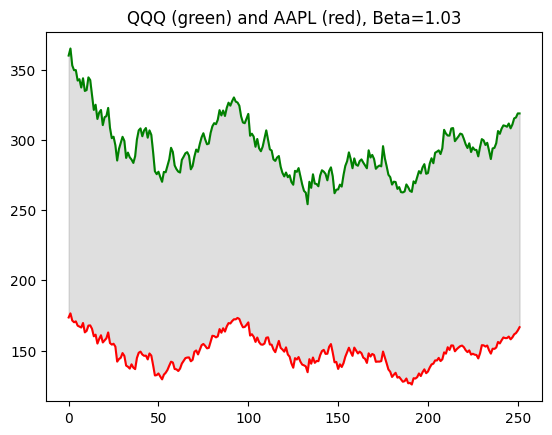  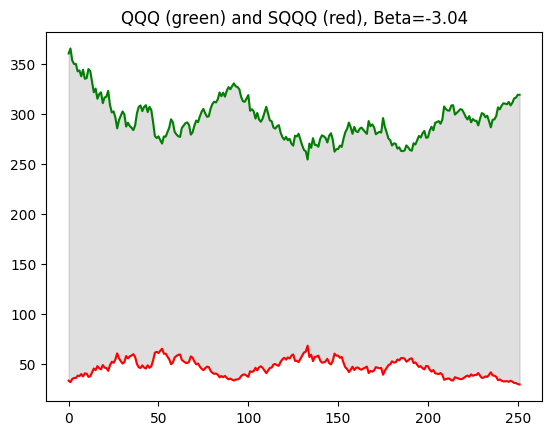


Here, we can observe that AAPL, with a beta of 1.03, follows QQQ's returns, where as SQQQ, an ETF made to have higher returns when QQQ goes down, has a beta of -3.04, which is highly uncorrelated.


A portfolio that is beta neutral is built upon the idea that it should be unexposed to the mouvements of the market, meaning a beta of zero. To do so, the weighted average of all holdings should total to a neutral beta.


***

From this information, one may be intrigued as to why a Beta-Neutral portfolio strategy is so attractive to investors and managers.

1. <u>Reduced market risk</u>: By constructing a portfolio that is beta-neutral, an investor can reduce their exposure to market risk. This means that the portfolio's returns are less affected by fluctuations in the broader market, making it more stable in the face of market volatility.

2. <u>Increased diversification</u>: A beta-neutral portfolio typically involves investing in a mix of assets with different levels of beta. This can lead to increased diversification, which can help reduce the overall risk of the portfolio.

3. <u>Improved risk-adjusted returns</u>: By balancing the portfolio's beta, investors can potentially achieve better risk-adjusted returns. This means that the returns achieved by the portfolio are higher relative to the amount of risk taken on.

4. <u>Potential for alpha generation</u>: By actively managing the portfolio's beta exposure, investors may be able to generate alpha, or excess returns above a benchmark. This can be achieved through skilled security selection and/or market timing, which can lead to outperformance relative to the broader market.

For this tutorial, we will use ETFs made up of Bonds, Futures and commodities as it is a simpler way to emulate returns, but is also safer than using stocks to generate Alpha.

**What we will do**
1. Import necessary packages
2. Select the necessary stocks depending on the selected exchange
3. Import the stock data and beta using yahoofinance python api
4. Calculated porfolio weights to minimize the total beta of our strategy
5. Upgrade the model
6. Possible improvements


# 1. To build our model, we first need to import the right packages

In [435]:
#Necessary imports for building our model
import statsmodels.api as sm
from scipy.optimize import minimize
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import yfinance as yf
from datetime import datetime
import datetime as dt
import numpy as np

# 2. For this example, we will use a diversified list of ETFs that are composed, once again, of bonds, futures and commodities: 
* Bond ETF that closely tracks a benchmark bond index, such as the **ProShares UltraPro Short 20+ Year Treasury** <u>TTT</u>, **iShares U.S. Treasury Bond ETF** <u>GOVT</u> and **Vanguard Total Bond Market ETF** <u>BND</u>
* Futures ETF that tracks a diversified basket of futures contracts, such as the **ProShares Hedge Replication ETF** <u>HDG</u>, **ProShares VIX Short-Term Futures ETF** <u>VIXY</u> and **ProShares Ultra VIX Short-Term Futures ETF** <u>UVXY</u>
* Commodities ETF that tracks a diversified basket of commodities, such as the **iShares S&P GSCI Commodity-Indexed Trust** <u>GSG</u>, **Invesco DB Commodity Index Tracking Fund** <u>DBC</u> and **United States Oil Fund LP** <u>USO</u>


For diversification purposes, we choose ETFs containing these types of assets, some being short (Negative Beta), or against, and some being long (Positive Beta), or positively correlated.

3. Here, we want to return the different prices and betas of the ETFs chosen for our strategy by using the yahoo finance python api


[*********************100%***********************]  9 of 9 completed


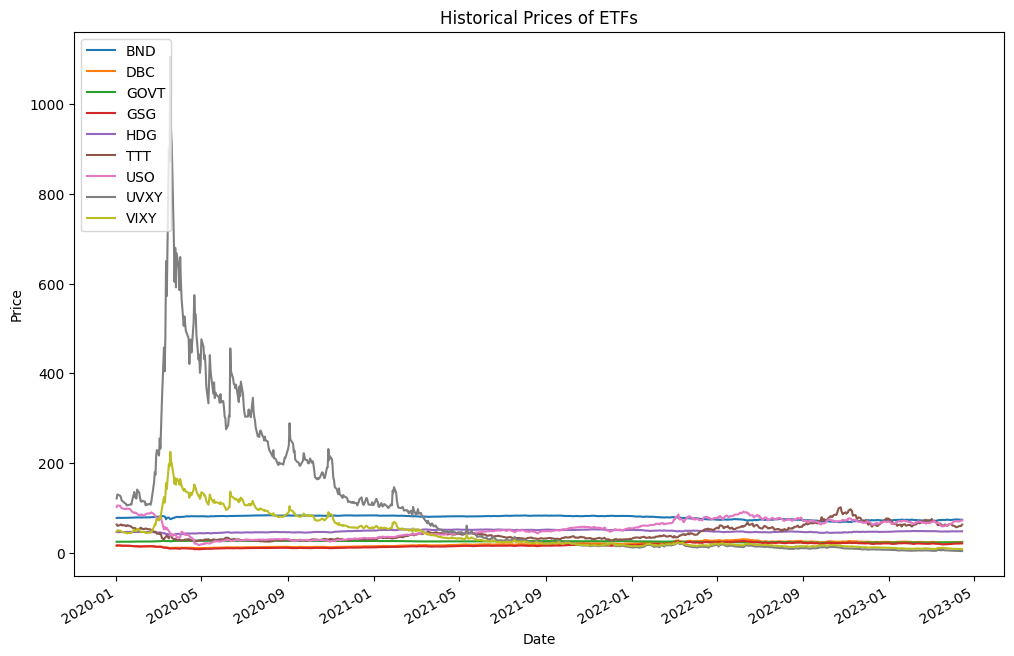

In [436]:
#Import the tickers and return a dataset of the price of the ETFs
tickers=["TTT","GOVT","BND","HDG","VIXY","UVXY","GSG","DBC","USO"]
today=datetime.today()
start_date="2020-01-01"
# Download historical prices for the tickers and calculate returns
prices = yf.download(tickers,start=start_date,end=today)['Adj Close']
prices.plot(figsize=(12,8))

# Set chart properties
plt.title('Historical Prices of ETFs')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
#Initiate empty beta dataframe
betas = pd.DataFrame(index=tickers, columns=['Beta'])

#Relative beta is calculated using returns of assets, we therefore need to calculate the returns using relative price changes to past data
returns=prices.pct_change().dropna()
returns=pd.DataFrame(returns)


In [437]:
prices.head()

,BND,DBC,GOVT,GSG,HDG,TTT,USO,UVXY,VIXY
Date,,,,,,,,,
2020-01-02,77.760803,15.874154,24.638941,16.290001,46.350948,63.178955,102.480003,121.300003,47.799999
2020-01-03,78.038628,16.063013,24.762188,16.510000,46.172791,60.328777,105.440002,130.100006,50.200001
2020-01-06,77.946030,16.092834,24.733746,16.510000,46.152996,61.239250,105.279999,128.199997,49.599998
2020-01-07,77.881203,16.082893,24.686348,16.459999,46.152996,62.149719,105.040001,127.300003,49.400002
2020-01-08,77.760803,15.844334,24.648420,16.150000,46.301456,63.337296,101.279999,123.699997,48.439999


Now that we have to estimate the weights of each ETFs in our portfolio so that the total beta equals zero: 
# <center>$$\mu_{i}=\alpha_{i}+\beta_{i}r_{m}+\epsilon_{i}$$ 

Given $\mu$ as returns of $ETF_i$, $\alpha$ being asset's alpha, or excess returns compared to benchmark, $\beta$ as beta of each ETF, $r$ being market return and $\epsilon$ as the error term.


Therefore, the returns of the whole portfolio $\mu_\pi$ is given as a a vectorial multiplication $\mu'\omega$, $\omega$ being the weight vector of all assets.

# 4. Let's code our strategy!

Let's first define some functions that we're going to use for our strategy:

In [438]:
#Calculating the beta of our portfolio is a very important part of the strategy, especially in the future when we will want to explore different horizons
def portfolio_beta(weights, betas):
    return np.dot(weights, betas)

#Given the fact that our portfolio need to be as close to a beta of zero as possible, calculating how close the current beta is to our zero target is very important since it allows us to minimize the deviation to our beta
def beta_deviation(weights, betas, target_beta):
    portfolio_beta = np.sum(weights * betas)
    deviation = (portfolio_beta - target_beta) ** 2
    return deviation


In [439]:
#Import the returns of s&p500 through time to calculate relative beta
sp500=yf.download('^GSPC', start=start_date, end=today)['Adj Close']
sp500_returns = yf.download('^GSPC', start=start_date, end=today)['Adj Close'].pct_change()[1:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [440]:
#Calculate betas of each ETFs in comparison with S&P500
for ticker in tickers:
    cov = np.cov(returns[ticker], sp500_returns)
    betas.loc[ticker, 'Beta'] = cov[0][1] / cov[1][1]


The constraint is defined using a Python dictionary with two keys:

**'type'**: This specifies the type of constraint. In this case, it is 'eq', which stands for equality constraint.

**'fun'**: This is a function that takes a numpy array of decision variables as input and returns a scalar value. The scalar value represents the left-hand side of the constraint equation, which must be equal to zero for the constraint to be satisfied.

In [441]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

Portfolio beta: 9.989982174829493e-10


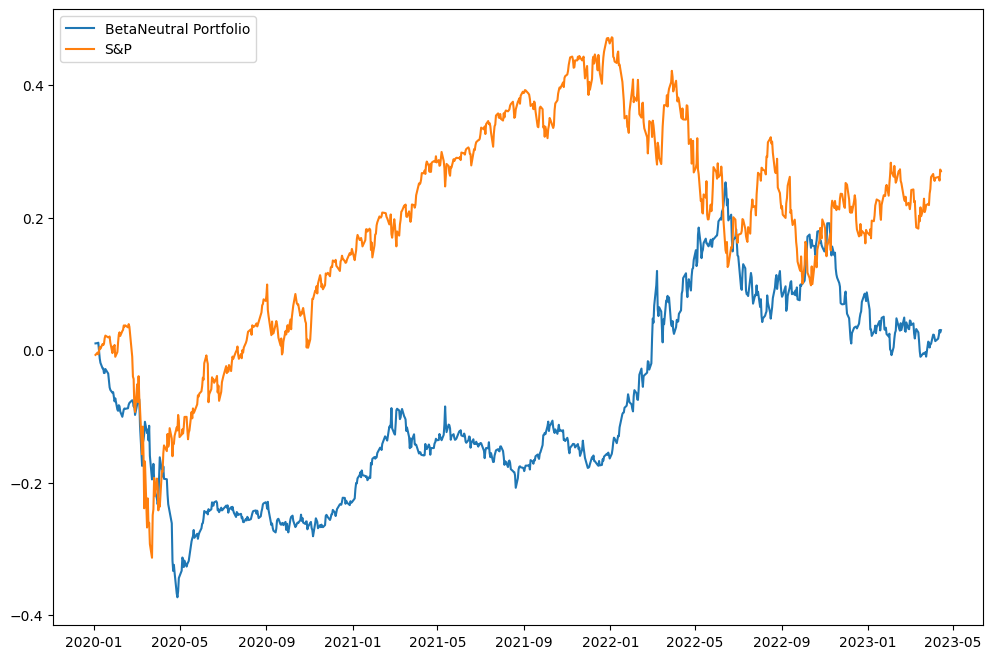

Date
2020-01-03    0.010281
2020-01-06    0.010793
2020-01-07    0.011316
2020-01-08   -0.001341
2020-01-09   -0.012589
                ...   
2023-04-10    0.017406
2023-04-11    0.022626
2023-04-12    0.030484
2023-04-13    0.026782
2023-04-14    0.030278
Length: 826, dtype: float64

In [442]:
bounds = tuple([(0, 1) for i in range(len(tickers))])
result = minimize(beta_deviation, np.ones(len(tickers))/len(tickers), args=(betas['Beta'], 0), constraints=cons, bounds=bounds)

weights = pd.Series(index=tickers, data=result.x)
portfolio_returns = (returns * weights).sum(axis=1)
portfolio_cumulative_returns = (1 + portfolio_returns).cumprod() - 1
sp500_cumulative_returns=(1+sp500_returns).cumprod()-1
portfolio_beta = portfolio_beta(weights, betas['Beta'])
print(f'Portfolio beta: {portfolio_beta}')

plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(portfolio_cumulative_returns,label="BetaNeutral Portfolio")
plt.plot(sp500_cumulative_returns,label="S&P")
plt.legend(loc="upper left")

plt.show()
alpha=portfolio_cumulative_returns[-1]
portfolio_cumulative_returns

Here, using minimization of beta difference, we realized a positive alpha of 3% from 2020 to now. The convictions of a beta-neutral are even more convincing, seing as the difficult markets of 2022 and 2023 don't influence our portfolio as much as S&P500 was and still is.

# 5.Rolling-Beta implementation


We can see that minimizing beta helps protect our portfolio against the mouvements of the S&P, our assets are therefore immunized from potential downturns in the economy. 
One important improvment would be to have a rolling beta, where weights are changed frequently to really tailor our portfolio to a more precise time-series.

In [443]:
# Download historical prices for ETFs and S&P 500
start_date = '2020-01-01'
today = pd.Timestamp.today().strftime('%Y-%m-%d')
etf_prices = yf.download(tickers, start=start_date, end=today)['Adj Close']
sp500 = yf.download('^GSPC', start=start_date, end=today)['Adj Close']
# Define function to calculate betas


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed


Next, we implement the function using a similar beta calculator for rolling datasets. We then recalculate betas every 100 days and update the weights at the end of each 100 days

In [444]:

def calculate_betas(prices, benchmark):
    returns = prices.pct_change().dropna()
    benchmark_returns = benchmark.pct_change().dropna()
    
    tickers = returns.columns.tolist()
    betas = pd.DataFrame(index=tickers, columns=['Beta'])
    
    for ticker in tickers:
        cov = np.cov(returns[ticker], benchmark_returns)
        betas.loc[ticker, 'Beta'] = cov[0][1] / cov[1][1]
    
    return betas

# Calculate betas for each ETF in comparison with S&P 500
betas = calculate_betas(etf_prices, sp500)
betas

,Beta
BND,0.065345
DBC,0.339582
GOVT,-0.047806
GSG,0.423105
HDG,0.339621
TTT,0.461577
USO,0.653157
UVXY,-3.709619
VIXY,-2.513706


Next we define our constraints and bounds in a similar way to the last strategy.

In [445]:
# Define optimization constraints and bounds
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple([(0, 1) for i in range(len(betas))])

# Calculate beta-neutral weights using rolling windows
window_size = 100
weights = []

Starting 100 days after the first block of 100 days, we analyze the weights that minimize the beta each time, and ponderate the weights accordingly to minimize the difference from our objective.

In [446]:


for i in range(100, len(etf_prices)):
    prices = etf_prices.iloc[i - window_size:i]
    current_betas = betas.loc[prices.columns, 'Beta']
    result = minimize(beta_deviation, np.ones(len(current_betas))/len(current_betas), args=(current_betas, 0), constraints=cons, bounds=bounds)
    weights.append(result.x)

weights = pd.DataFrame(weights, index=etf_prices.index[window_size:], columns=etf_prices.columns)

# Calculate portfolio returns and compare to S&P 500
portfolio_returns = (etf_prices.pct_change() * weights).sum(axis=1).dropna()
portfolio_cumulative_returns = (1 + portfolio_returns).cumprod() - 1
sp500_cumulative_returns = (1 + sp500.pct_change()).cumprod() - 1

# Calculate portfolio beta
portfolio_betas = calculate_betas(etf_prices, sp500)
portfolio_beta = np.sum(portfolio_betas['Beta'] * weights.iloc[-1])
print(f'Portfolio beta: {portfolio_beta}')
alpha=portfolio_cumulative_returns[-1]
alpha


Portfolio beta: 1.0131444017069668e-09


0.4250705485217283

Plot our results

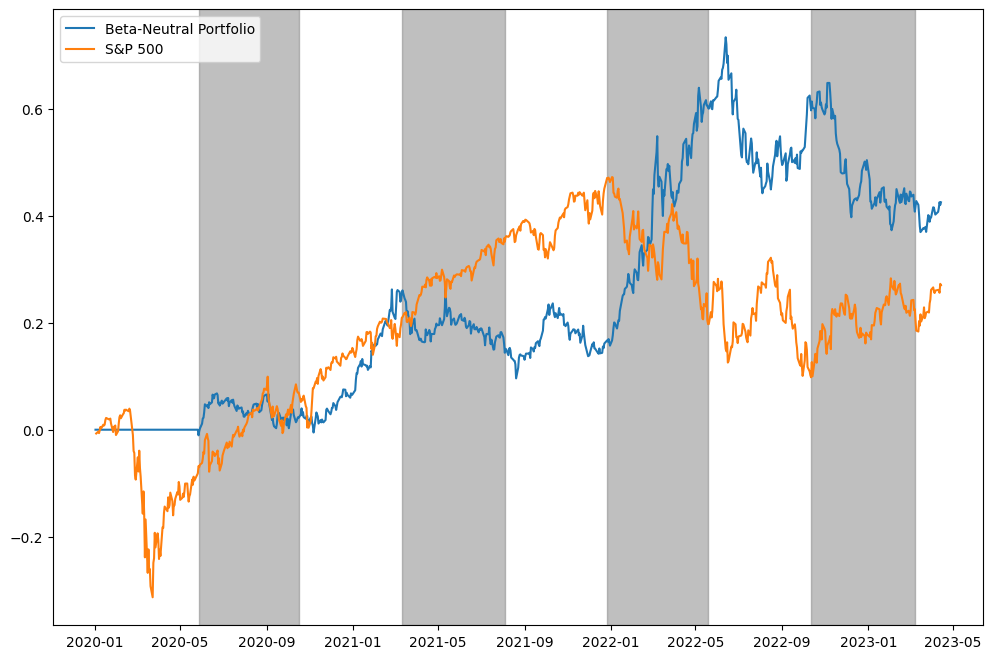

In [447]:
plt.rcParams['figure.figsize'] = [12, 8]


plt.plot(portfolio_cumulative_returns, label="Beta-Neutral Portfolio")
plt.plot(sp500_cumulative_returns, label="S&P 500")
interval = 100
x=0
for i in range(0, len(sp500_cumulative_returns), interval):

    start_index = sp500_cumulative_returns.index[i]
    end_index = sp500_cumulative_returns.index[min(i+interval, len(sp500_cumulative_returns)-1)]
    x+=1
    if x % 2 ==0:
        plt.axvspan(start_index, end_index, color='grey', alpha=0.5)
plt.legend(loc="upper left")
plt.show()

Using our Beta-Neutral strategy with a rolling window, we see that we not only outperform our S&P benchmark, but we also generate an alpha of 42%.

# 6. Possible improvements

1. Incorporate transaction costs: The code does not currently take into account transaction costs, which can significantly impact the performance of the strategy. To get a more realistic estimate of the strategy's performance one could add a transaction cost model and simulate the costs of trading the portfolio.

2. Consider alternative beta estimates: The code uses the market beta as the sole factor to estimate the beta of each ETF. However, other factors, such as sector or style beta, can also impact the performance of an ETF. Incorporating additional factors into the beta estimate can improve the accuracy of the portfolio weights.

3. Estimate the correlation between on ETFs and an other to better modulate our returns based on the risk taken. This method is known as a Markowtitz portfolio management strategy and is commonly used in different Hedge Funds and Market Making firms